# Program - Plot SCAM cn_tp, xy_seris, xy_profile

**Purpose**
Plot SCAM cn_tp, xy_seris, xy_profile

**Content**
- read data
- plot SCAM cn_tp, xy_seris, xy_profile

**Author:** Yi-Hsuan Chen (yihsuan@umich.edu)

**Date:** 
November 2023

**Reference program:**



In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

## Functions

### Read data

In [2]:
def read_scam_data (choice, datapath="/Users/yi-hsuanchen/Downloads/yihsuan/scripts/python/data_test/"): 

    func_name = "read_scam_data"
    
    if (choice == "scam_tw606_cam5phys"):        
        fname = datapath+"scam_tw606_cam5phys.camrun.cam.h0.2006-01-17-10800.nc"
        scm_list = {'fname':fname,
                    'label':'CAM5_phys',
                    'ln_style':'b-',
                   }

    elif (choice == "scam_tw606_phys"):        
        fname = datapath+"scam_tw606_taiphys.camrun.cam.h0.2006-01-17-10800.nc"
        scm_list = {'fname':fname,
                    'label':'Tai_phys',
                    'ln_style':'r-',
                   }
        
    else:
        error_msg = f"ERROR: function [{func_name}] does not support [{choice}]."
        raise ValueError(error_msg)        
    
    #--- read files
    da_return = xr.open_mfdataset(fname) 

    return da_return, scm_list

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    choice = "scam_tw606_cam5phys"

    da1, scm_list1 = read_scam_data(choice)    
    
#da1
#scm_list1['label']

### ax_def_xy_series

In [3]:
def ax_def_xy_series (ax, var, opt_xy):

    #-------------
    # shared res
    #-------------
    
    #--- set grids
    ax.grid(True)
    ax.minorticks_on()
    #ax.grid(False, axis = "x")  # turn off x grids

    #--- set tick mark sizes
    fontsize_tm = 12  # set tick mark size
    ax.tick_params(axis='x', labelsize = fontsize_tm)
    ax.tick_params(axis='y', labelsize = fontsize_tm)

    #--- set x range
    ax.set_xlim([0,len(var)])
    
    #--- set x or y labels
    fontsize_label = 18
    
    ax.set_xlabel("Time step")  
      ### set font size, ax.set_ylabel("A", fontsize = fontsize_label)
    
    #--- inverse axes
    #ax.invert_yaxis()
    
    #-------------
    # custom res
    #-------------    
    
    if (opt_xy == "same_var"):
        ax.set_ylabel(var.attrs['long_name']+" ("+var.attrs['units']+")")
        ax.set_title(var.attrs['long_name'], loc='left')
        ax.set_title(var.attrs['units'], loc='right')    
        
    elif (opt_xy == "same_units"):
        ax.set_ylabel(var.attrs['units']+")")
        ax.set_title(var.attrs['units'], loc='right')    


### Plot - xy_series

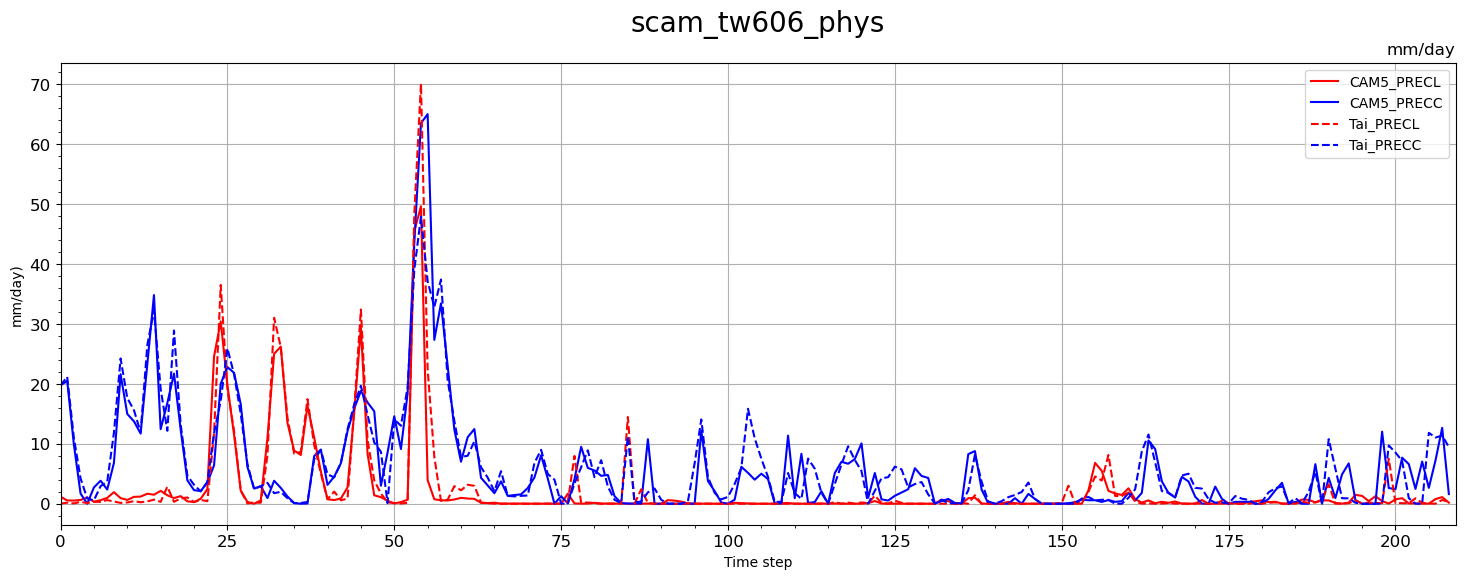

In [4]:
def plot_scam_xy_series(ax, da, varname,
                        ln="b-", label="LABEL",
                        opt_xy = None, 
                        ):
    
    #--- read variable
    var = yhc.unit_convert(da.get(varname)[:,0,0])

    #--- get time steps
    var_step = np.arange(0, len(var.time))
    
    #--- plot    
    ax1.plot(var_step, var, ln, label=label,
             )
    
    ax1.legend()
    ax_def_xy_series(ax1, var, opt_xy)
    
#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    choice = "scam_tw606_cam5phys"
    da1, scm_list1 = read_scam_data(choice)    
 
    choice = "scam_tw606_phys"
    da2, scm_list2 = read_scam_data(choice)    

    #--- open ax
    fig, ax1 = plt.subplots(1,1, figsize=(18, 6))   # 1 row, 3 columns
    
    #--- set main title
    maintitle = choice
    ax1.set_title(maintitle, fontsize=20, y=1.05)
    
    #--- plot
    #opt_xy="same_var"
    opt_xy="same_units"
    
    varname1="PRECL"
    label1 = "LABEL"
    
    plot_scam_xy_series(ax1, da1, varname="PRECL", ln="r-", label="CAM5_PRECL", opt_xy=opt_xy)
    plot_scam_xy_series(ax1, da1, varname="PRECC", ln="b-", label="CAM5_PRECC", opt_xy=opt_xy)
    plot_scam_xy_series(ax1, da2, varname="PRECL", ln="r--", label="Tai_PRECL", opt_xy=opt_xy)
    plot_scam_xy_series(ax1, da2, varname="PRECC", ln="b--", label="Tai_PRECC", opt_xy=opt_xy)


In [5]:
#yhc.lib('pltxy')

### ax_def_xy_profiles

In [6]:
def ax_def_xy_profiles (ax, xx, yy, opt_xy, vert_coord):

    #-------------
    # shared res
    #-------------
    
    #--- set grids
    ax.grid(True)
    ax.minorticks_on()
    #ax.grid(False, axis = "x")  # turn off x grids

    #--- set tick mark sizes
    fontsize_tm = 12  # set tick mark size
    ax.tick_params(axis='x', labelsize = fontsize_tm)
    ax.tick_params(axis='y', labelsize = fontsize_tm)
    
    #--- set x or y labels
    fontsize_label = 15
    ax.set_ylabel(yy.attrs['long_name']+" ("+yy.attrs['units']+")", fontsize=fontsize_label)  
      ### set font size, ax.set_ylabel("A", fontsize = fontsize_label)
    
    #--- inverse axes
    #if (vert_coord == "p"):
    #    ax.invert_yaxis()
    
    #-------------
    # custom res
    #-------------    
        
    if (opt_xy == "same_var"):
        ax.set_xlabel(xx.attrs['long_name']+" ("+xx.attrs['units']+")", fontsize=fontsize_label)
        #ax.set_title(xx.attrs['long_name']+" ("+xx.attrs['units']+")", loc="left", fontsize=fontsize_label)
        #ax.set_title(xx.attrs['long_name'], loc='left',fontsize=fontsize_label)
        #ax.set_title(xx.attrs['units'], loc='right', fontsize=fontsize_label)    
        
    elif (opt_xy == "same_units"):
        ax.set_xlabel(xx.attrs['units'], fontsize=fontsize_label)
        ax.set_title(xx.attrs['units'], loc='right', fontsize=fontsize_label)    

### Plot - xy_profile

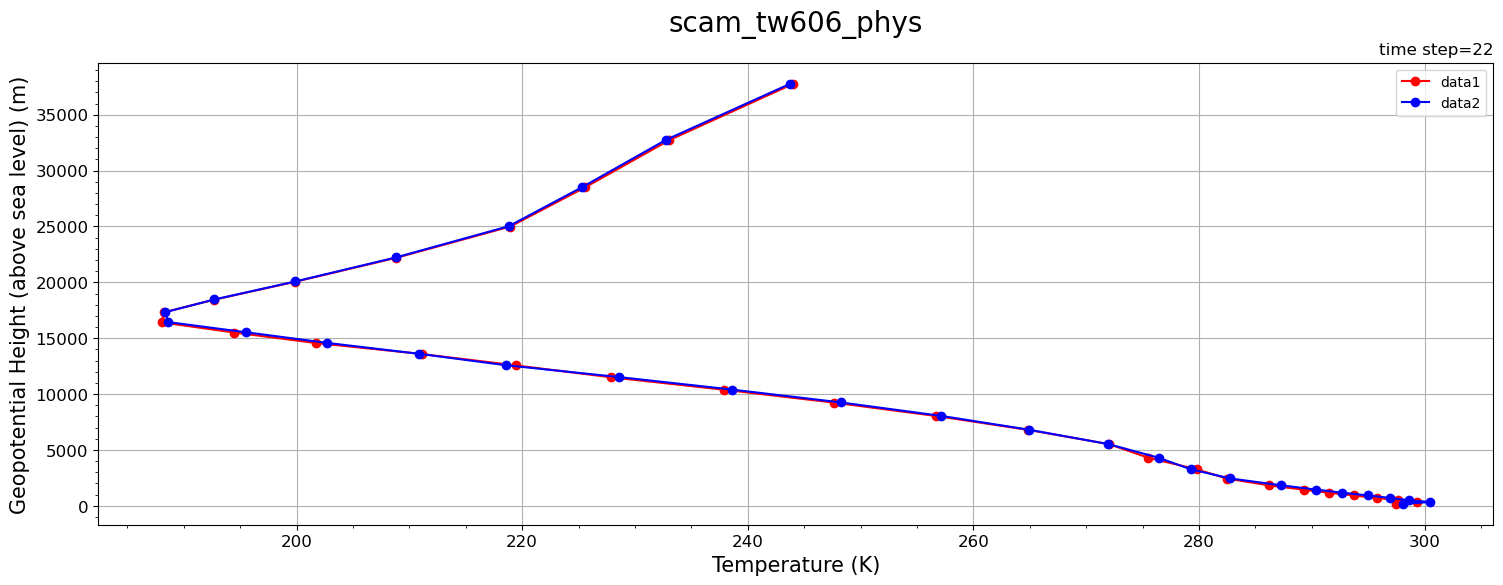

In [22]:
def plot_scam_xy_profiles(ax, da, varname, time_step, vert_coord="p",
                          ln="b-", label="LABEL",
                          opt_xy = None, 
                        ):
    func_name = "plot_scam_xy_profiles"
    
    #--- read variable
    xx = yhc.unit_convert(da.get(varname)[time_step,:,0,0])

    #--- get vertical coordinate
    if (vert_coord == "geoh"):
        yy = da.get("Z3")[time_step,:,0,0]
    
    elif (vert_coord == "p"):
        if 'lev' in xx.coords: 
            hya=da.get("hyam"); hyb=da.get("hybm")
        elif 'ilev' in xx.coords: 
            hya=da.get("hyai"); hyb=da.get("hybi")
        else:
            error_msg = f"ERROR: function [{func_name}] either lev or ilev is not a coordinate variable"
            raise ValueError(error_msg)        
            
        p0 = da.get("P0")
        ps = da.get("PS")[time_step,0,0]
        
        yy = 0.01 * (hya*p0 + hyb*ps)
        yy.attrs['long_name']="Pressure"
        yy.attrs['units']="hPa"
        
    else:
        error_msg = f"ERROR: function [{func_name}] does not support vert_coord=[{vert_coord}]."
        raise ValueError(error_msg)        
        
    #--- plot    
    ax.plot(xx, yy, ln, label=label,
             )
    
    ax.legend()
    #ax.invert_yaxis()

    ax_def_xy_profiles(ax, xx, yy, opt_xy, vert_coord)
    ax.set_title("time step="+str(time_step), loc='right')    
    
#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    choice = "scam_tw606_cam5phys"
    da1, scm_list1 = read_scam_data(choice)    
 
    choice = "scam_tw606_phys"
    da2, scm_list2 = read_scam_data(choice)    
    
    #--- open ax
    fig, ax1 = plt.subplots(1,1, figsize=(18, 6))   # 1 row, 3 columns
    
    #--- set main title
    maintitle = choice
    ax1.set_title(maintitle, fontsize=20, y=1.05)
    
    #--- plot
    opt_xy="same_var"
    #opt_xy="same_units"
    
    #vert_coord="p"
    vert_coord="geoh"
    
    varname1="T"
    label1 = "LABEL"

    time_step = 22
    plot_scam_xy_profiles(ax1, da1, vert_coord=vert_coord, varname=varname1, time_step=time_step, ln='r-o', label="data1", opt_xy=opt_xy)
    plot_scam_xy_profiles(ax1, da2, vert_coord=vert_coord, varname=varname1, time_step=time_step, ln='b-o', label="data2", opt_xy=opt_xy)

    if (vert_coord == "p"): ax1.invert_yaxis()
    
    ymin=0; ymax=10000; xmin=240; xmax=300
    #ax1.set_ylim(ymin,ymax)
    #ax1.set_xlim(xmin,xmax)

### Plot - cn_tp

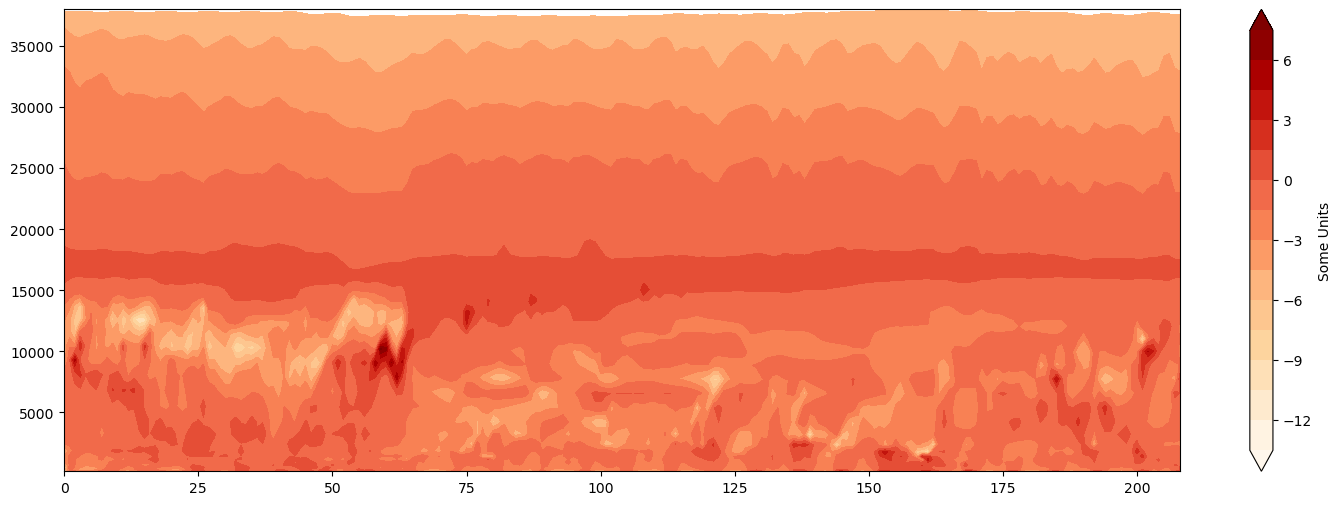

In [46]:
def plot_scam_cn_tp(ax, da, varname,
                    vert_coord="geoh"):
    func_name = "plot_scam_cn_tp"
    
    #------------------------------------------------------
    # read the variable, time, and vertical coordinates
    #------------------------------------------------------
    
    #--- read variable
    var = yhc.unit_convert(da.get(varname)[:,:,0,0])

    #--- get time steps
    time_step = np.arange(0, len(var.time))
    time_step_tmp = np.tile(time_step, (var.shape[1],1))
    time_step_2d = time_step_tmp.transpose()
    
    #--- get vertical coordinate
    if (vert_coord == "geoh"):
        yy = da.get("Z3")[:,:,0,0]
    
    elif (vert_coord == "p"):
        if 'lev' in var.coords: 
            hya=da.get("hyam"); hyb=da.get("hybm")
            lev_name='lev'
        elif 'ilev' in var.coords: 
            hya=da.get("hyai"); hyb=da.get("hybi")
            lev_name='ilev'
        else:
            error_msg = f"ERROR: function [{func_name}] either lev or ilev is not a coordinate variable"
            raise ValueError(error_msg)        
            
        p0 = da.get("P0")
        ps = da.get("PS")[:,0,0]
        
        yy = 0.01 * (hya*p0 + hyb*ps)
        yy.attrs['long_name']="Pressure"
        yy.attrs['units']="hPa"
        yy = yy.transpose("time",lev_name)

    #------------------------------------------------------
    # plot
    #------------------------------------------------------
    plot_cn = ax.contourf(time_step_2d, yy, var, 15, cmap="OrRd", extend="both")  # automatically 10 levels  reversed cmap "OrRd_r"

    #--- set label bar
    fig.colorbar(plot_cn, orientation='vertical', label='Some Units')
    
    #yhc.printv(yy,'r')
    #yhc.printv(var,'g')
    #yhc.printv(time_step_2d,'b')
    
    
#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    #--- open ax
    fig, ax1 = plt.subplots(1,1, figsize=(18, 6))   # 1 row, 3 columns
    
    choice = "scam_tw606_cam5phys"
    da1, scm_list1 = read_scam_data(choice) 
    
    varname = "QRL"
    plot_scam_cn_tp(ax1, da1, varname)
    

    
    

## Plot - 

In [ ]:
#yhc.lib("fdef")   # check out yhc library